In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# make small grid

dx = 500
x = np.arange(0, 25000, dx)
x_node = x + (dx/2)

Hstar = 0.5
etab = np.zeros(len(x)) # bedrock elevation, m
etab[:] = np.linspace(10, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x))
eta = etab + H

In [3]:
kqs = 0.041
I = 0.03

In [4]:
r = 10.
A = (1./3.) * x**2

# Q = r * A
# Q = (r * a * x**(1 + Pxb))/(1 + Pxb)

U = 0.0001

In [5]:
# set up parameters
K = 1e-6

beta = 0.0005

psi = 0.0005

D = 0.01 # grain size
phi = 0.1 # porosity
baselevel_rate = 0.0001 # baselevel fall rate

In [6]:
kxb = 25
Pxb = 1./5.
kb = 8.3e-8

B_valley = kxb * (x_node**Pxb)
B_basin = (2./3.) * x_node

Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb)

In [7]:
def model(x, dx, x_node,
          K, beta,
          D, phi, Hstar, psi,
          kb, kqs, I, r, B_valley, B_basin, Q,
          etab, H, eta,
          baselevel_rate,
          num_steps = 1):
    
    q = Q/B_valley
    # dt = 0.2 * dx * dx / (kqs * q[-1]) # try changing to 10, 5, or 1 if this is unstable
    dt = 500
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x))
    
    H[-1] = 0
    E[-1] = baselevel_rate
    q[0] = 0
    Qs[0] = 0
    ql[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= baselevel_rate * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc Rh
#         width = (kb * Q[1:] * (S ** (7/6))) / (D**(3/2))
#         depth = (0.09801 * D) / S
#         Rh_efficiency = 1 - np.exp(-width/(2*depth))
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        # Qs[1:] = kqs * I * Q[:-1] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1]
        # Eb_p[:-1] = K * Q[:-1] * S**(7./6.) * alpha[:-1]
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc grain attrition
        atr = Qs * psi
        
        # calc equilibrium lateral supply
        # ql[1:] = ((baselevel_rate * gamma) / psi) * (1 - np.exp(-psi/(3 * x[1:])))
        # ql[24:] = 0
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p[:-1]) # - ql[1:])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, atr, Eh, E, etab, H, eta)

In [8]:
#now write a test
num_steps = 40000
test_run = [x, dx, x_node, 
            K, beta, 
            D, phi, Hstar, psi,
            kb, kqs, I, r, B_valley, B_basin, Q,
            etab, H, eta,
            baselevel_rate,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, atr, Eh, E, etab, H, eta) = model(*test_run)

20000000.0


In [9]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 0.e+00])

In [10]:
S

array([0.02700046, 0.02096582, 0.01733486, 0.01495411, 0.01323485,
       0.01191267, 0.01085245, 0.00997718, 0.0092391 , 0.0086066 ,
       0.00805768, 0.00757637, 0.00715071, 0.0067715 , 0.00643154,
       0.00612504, 0.00584734, 0.00559458, 0.00536359, 0.0051517 ,
       0.00495665, 0.00477652, 0.00460968, 0.00445471, 0.0043104 ,
       0.00417568, 0.00404963, 0.00393144, 0.00382038, 0.00371584,
       0.00361724, 0.00352409, 0.00343595, 0.00335242, 0.00327313,
       0.00319778, 0.00312607, 0.00305774, 0.00299256, 0.0029303 ,
       0.00287077, 0.00281379, 0.0027592 , 0.00270684, 0.00265659,
       0.00260831, 0.00256189, 0.00251722, 0.0024742 ])

In [11]:
alpha_mine = (kqs * I * beta)/(K - (K*np.exp(-beta * x)) + (kqs * I * beta))

In [12]:
# S_an = ((1/((K*Q*alpha) - 
#             (K * Q * alpha * np.exp(-beta * x)) + 
#             (K * Q))) * ((U * B_valley)/alpha)) ** (6./7.)

# just see if ben's solution works
A1 = beta * kqs * I
A2 = (1 - np.exp(-beta * x)) * K
A3 = beta * kqs * I

alpha_Ben = A1 / (A2 + A3)

term_1 = 1 - np.exp(-beta * x)
term_2 = K * Q * alpha_Ben
term_3 = term_1 * term_2 + K * Q
term_4 = (U * B_valley) / alpha_Ben

S_an_Ben = (term_4 / term_3) ** (6 / 7)

# S_an_mine = ((1/((K*Q[1:]*alpha_mine[1:]) - 
#             (K * Q[1:] * alpha_mine[1:] * np.exp(-beta * x[1:])) + 
#             (K * Q[1:]))) * ((U * B_valley[:-1])/alpha_mine[1:])) ** (6./7.)

S_an_mine = ((1/((K*Q*alpha_mine) - 
            (K * Q * alpha_mine * np.exp(-beta * x)) + 
            (K * Q))) * ((U * B_valley)/alpha_mine)) ** (6./7.)

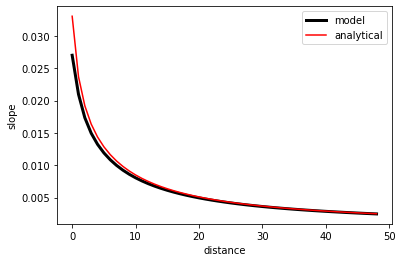

In [13]:
plt.plot(S, label = 'model', linewidth = 3, color = 'k')
plt.plot(S_an_Ben[1:], label = 'analytical', color = 'red')
plt.xlabel('distance')
plt.ylabel('slope')
plt.legend()

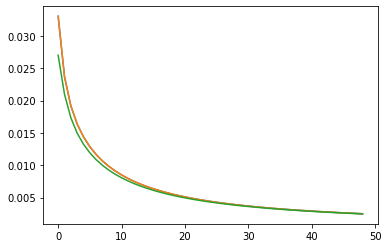

In [14]:
# need to see if my analytical soln is the same as Ben's
plt.plot(S_an_mine[1:])
plt.plot(S_an_Ben[1:])
plt.plot(S)

In [15]:
eta_an = -(S_an_mine * x)

In [16]:
baselevel_difference = eta[-1] - eta_an[-1]

eta_adj = eta - eta[-1]
eta_an_adj = eta_an + baselevel_difference - eta[-1]

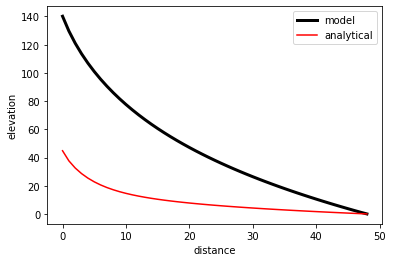

In [17]:
plt.plot(eta_adj[1:], label = 'model', linewidth = 3, color = 'k')
plt.plot(eta_an_adj[1:], label = 'analytical', color = 'red')
plt.xlabel('distance')
plt.ylabel('elevation')
plt.legend()